# Practicing on the IR color table 

With Blue Marble in the background, seen through transparency in the lower-middle cloud range 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd 
from pathlib import Path
import os
from subprocess import run
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.colors as mcolors
from matplotlib.image import imread

In [2]:
# Read in huge Blue Marble image 
# --- Place this code BEFORE your 1000-frame loop (Load ONCE) ---

# Disable the decompression bomb check
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# --- Configuration (MUST match your image and desired georeference) ---
STATIC_MAP_FILE = '/Users/bmapes/Box/Sky_Symphony_Box/BlueMarble.200408.3x21600x10800.jpg' 
FULL_WORLD_EXTENT = [-180, 180, -90, 90] 
try:
    # Load the single satellite image file ONLY ONCE
    BASE_IMAGE_DATA = imread(STATIC_MAP_FILE)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: Static map file '{STATIC_MAP_FILE}' not found. Please download a high-res Blue Marble image and save it to this name.")

In [3]:
# Custom color scale, including transparency to see Blue Marble underneath  
# THIS ONE WAS A BIT GAUZY, MAKE MORE TRANSPARENCY AT LOW LEVELS / HIGH TB

color_points = [
    (190, "#dc05ef", 1.0),  # magenta 
    (222, "#0589ef", 1.0),  # blue (color enhancement ends)
    (240, "#00ffff", 1.0),  # cyan
    (250, "#716f6f", 1.0),  # darker gray 
    (270, "#c5c6c6", 1.0),  # light-mid gray
    (280, "#ffffff", 0.9),  # white semitrans light gray
    (290, "#ffffff", 0.6),  # white point surface
    (300, "#ffffff", 0.1),  # SST point water
    (305, "#ffffff", 0.4),  # bush green cool surface --> WHITE
    (310, "#ff8000", 1.0),  # HOT surface orange, see https://html-color.codes/
    (340, "#000000", 1.0)  # HOTHOT surface black
]

vmin = 190; vmax=340 

cmap = LinearSegmentedColormap.from_list("custom", [
    ((v - vmin) / (vmax - vmin), to_rgba(c, a)) for v, c, a in color_points
])

In [8]:
# Test colors for one image 

data_folder = Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/IRfiles/")  
nc_files = sorted(data_folder.glob("*.nc4"))

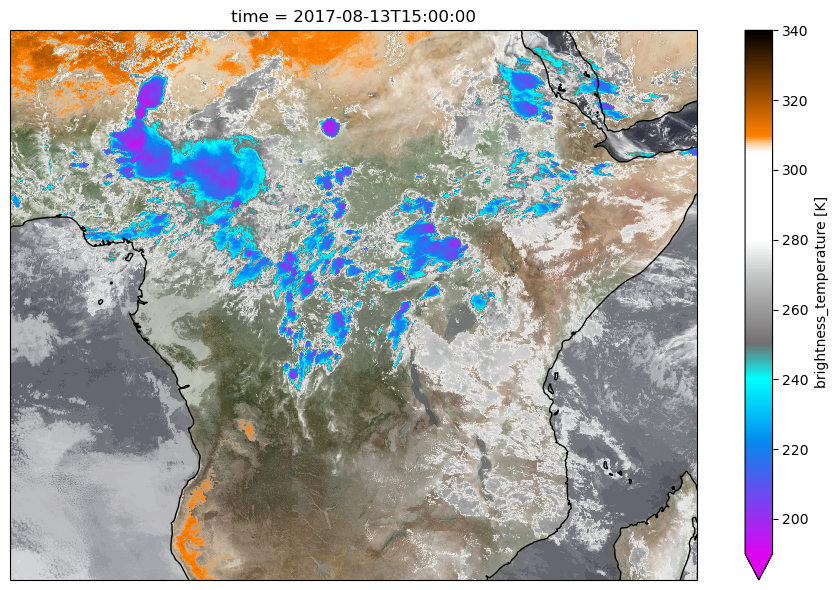

In [10]:
ds = xr.open_dataset(nc_files[10])  # 21Z = 18+24-15 cold 
#ds = xr.open_dataset(nc_files[200-12 +24*0])      # Sahel coast crossing 

Tb = ds.Tb[0]

# Define extent from coast file
extent = [ds.lon.min().values, ds.lon.max().values,ds.lat.min().values, ds.lat.max().values]

# Plot data on top of map image, there is some transparency 
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Background image: stock image, or slow web call, tiles keeps crashing on me, sigh
ax.imshow(BASE_IMAGE_DATA,
  origin='upper',
  transform=ccrs.PlateCarree(),
  extent=FULL_WORLD_EXTENT)

ax.coastlines()

Tb.interpolate_na(dim="lon", method="linear", max_gap=2).plot.imshow(
    ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin,vmax=vmax,\
    add_colorbar=True, #cbar_kwargs={'label': 'Brightness Temperature [K]'}
)
plt.tight_layout()
